In [1]:
from neurodiffeq import diff
from neurodiffeq.networks import FCNN
from neurodiffeq.pde import solve2D, Monitor2D, PredefinedExampleGenerator2D
from neurodiffeq.pde import CustomBoundaryCondition, Point, DirichletControlPoint, NeumannControlPoint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
RETRAIN_PROBLEM_C = True

In [3]:
def solution_analytical_problem_c(x, y):
    return np.log(1+x**2+y**2)

def gradient_solution_analytical_problem_c(x, y):
    return 2*x / (1+x**2+y**2), 2*y / (1+x**2+y**2), 

In [4]:
# creating control points for Dirichlet boundary conditions

edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

direction_theta  =  np.pi*2/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

dirichlet_control_points_problem_c = []
point_x, point_y = 0.0, -1.0
for i_edge in range(6):
    for i_step in range(points_on_each_edge-1):
        dirichlet_control_points_problem_c.append(
            DirichletControlPoint(
                loc=(point_x, point_y), 
                val=solution_analytical_problem_c(point_x, point_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

# dummy control points to form closed domain    

radius_circle = 1.0 / np.sin(np.pi/6)
center_circle_x = radius_circle * np.cos(np.pi/6)
center_circle_y = 0.0

dirichlet_control_points_problem_c_dummy = []
for theta in np.linspace(-np.pi*5/6, np.pi*5/6, 60):
    point_x = center_circle_x + radius_circle*np.cos(theta)
    point_y = center_circle_y + radius_circle*np.sin(theta)
    dirichlet_control_points_problem_c_dummy.append(
        DirichletControlPoint(
            loc=(point_x, point_y),
            val=solution_analytical_problem_c(point_x, point_y)
        )
    )
    
# all Dirichlet control points

dirichlet_control_points_problem_c_all = \
    dirichlet_control_points_problem_c + dirichlet_control_points_problem_c_dummy

In [5]:
# creating control points for Neumann boundary condition

edge_length = 2.0 / np.sin(np.pi/3) / 4
points_on_each_edge = 11
step_size = edge_length / (points_on_each_edge-1)

normal_theta = np.pi/6

direction_theta  = -np.pi*1/3
left_turn_theta  =  np.pi*1/3
right_turn_theta = -np.pi*2/3

neumann_control_points_problem_c = []
point_x, point_y = 0.0, 1.0
for i_edge in range(6):
    normal_x = np.cos(normal_theta)
    normal_y = np.sin(normal_theta)
    for i_step in range(points_on_each_edge-1):
        grad_x, grad_y = gradient_solution_analytical_problem_c(point_x, point_y)
        neumann_val = grad_x*normal_x + grad_y*normal_y
        neumann_control_points_problem_c.append(
            NeumannControlPoint(
                loc=(point_x, point_y), 
                val=neumann_val,
                normal_vector=(normal_x, normal_y)
            )
        ) 
        point_x += step_size*np.cos(direction_theta)
        point_y += step_size*np.sin(direction_theta)
    direction_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta
    normal_theta += left_turn_theta if (i_edge % 2 == 0) else right_turn_theta

# dummy control points to form closed domain
    
radius_circle = 1.0 / np.sin(np.pi/6)
center_circle_x = -radius_circle * np.cos(np.pi/6)
center_circle_y = 0.0

neumann_control_points_problem_c_dummy = []
for theta in np.linspace(np.pi*1/6, np.pi*11/6, 60):
    point_x = center_circle_x + radius_circle*np.cos(theta)
    point_y = center_circle_y + radius_circle*np.sin(theta)
    normal_x = np.cos(theta)
    normal_y = np.sin(theta)
    grad_x, grad_y = gradient_solution_analytical_problem_c(point_x, point_y)
    neumann_val = grad_x*normal_x + grad_y*normal_y
    neumann_control_points_problem_c_dummy.append(
        NeumannControlPoint(
                loc=(point_x, point_y), 
                val=neumann_val,
                normal_vector=(normal_x, normal_y)
        )
    )
    
# all Neumann control points

neumann_control_points_problem_c_all = \
    neumann_control_points_problem_c + neumann_control_points_problem_c_dummy

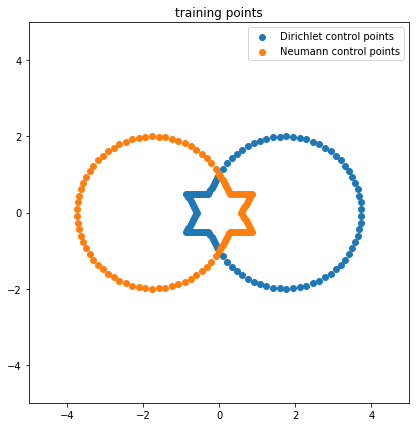

In [6]:
plt.figure(figsize=(7, 7))
plt.scatter(
    [p.loc[0] for p in dirichlet_control_points_problem_c_all],
    [p.loc[1] for p in dirichlet_control_points_problem_c_all],
    label='Dirichlet control points'
)
plt.scatter(
    [p.loc[0] for p in neumann_control_points_problem_c_all],
    [p.loc[1] for p in neumann_control_points_problem_c_all],
    label='Neumann control points'
)
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('training points');

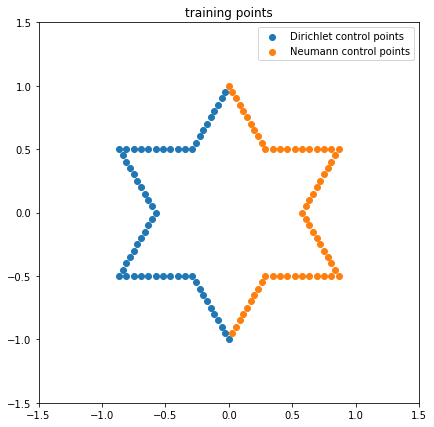

In [7]:
plt.figure(figsize=(7, 7))
plt.scatter(
    [p.loc[0] for p in dirichlet_control_points_problem_c],
    [p.loc[1] for p in dirichlet_control_points_problem_c],
    label='Dirichlet control points'
)
plt.scatter(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c],
    label='Neumann control points'
)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('training points');

In [8]:
cbc_problem_c = CustomBoundaryCondition(
    dirichlet_control_points=dirichlet_control_points_problem_c_all,
    neumann_control_points=neumann_control_points_problem_c_all,
    center_point=Point(loc=(0.0, 0.0))
)

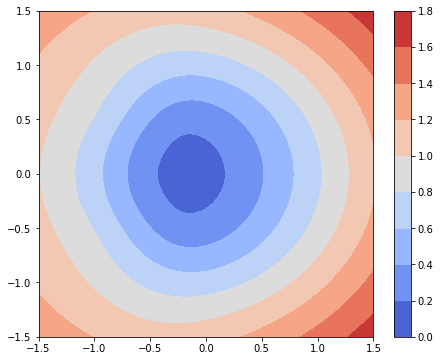

In [9]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
a_ds = cbc_problem_c.a_d(xx, yy)
a_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, a_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

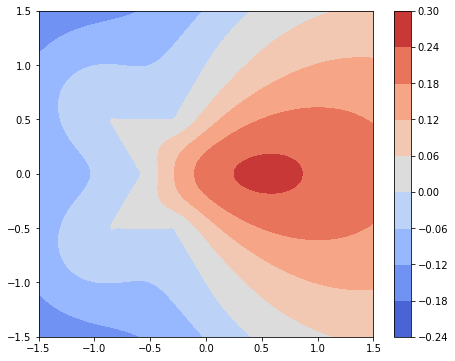

In [10]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ds = cbc_problem_c.l_d(xx, yy)
l_ds.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ds, cmap='coolwarm')
cbar = fig.colorbar(cs)

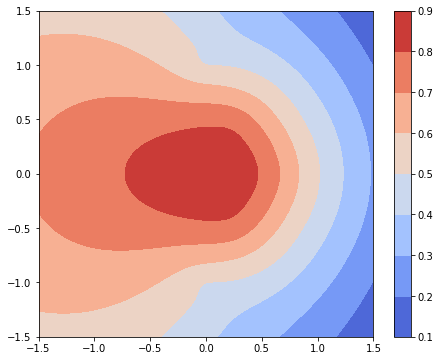

In [11]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
gs = cbc_problem_c.g(xx, yy)
gs.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, gs, cmap='coolwarm')
cbar = fig.colorbar(cs)

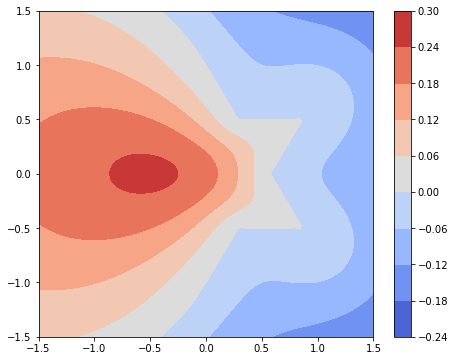

In [12]:
xs = torch.linspace(-1.5, 1.5, 101)
ys = torch.linspace(-1.5, 1.5, 101)
xx, yy = torch.meshgrid(xs, ys)
l_ms = cbc_problem_c.l_m(xx, yy)
l_ms.detach().numpy()

fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.contourf(xx, yy, l_ms, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [13]:
def get_grid(x_from_to, y_from_to, x_n_points=100, y_n_points=100, as_tensor=False):
    x_from, x_to = x_from_to
    y_from, y_to = y_from_to
    if as_tensor:
        x = torch.linspace(x_from, x_to, x_n_points)
        y = torch.linspace(y_from, y_to, y_n_points)
        return torch.meshgrid(x, y)
    else:
        x = np.linspace(x_from, x_to, x_n_points)
        y = np.linspace(y_from, y_to, y_n_points)
        return np.meshgrid(x, y)

def to_np(tensor):
    return tensor.detach().numpy()

In [14]:
xx_train, yy_train = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=28, y_n_points=28,
    as_tensor=True
)
is_in_domain_train = cbc_problem_c.in_domain(xx_train, yy_train)
xx_train, yy_train = to_np(xx_train), to_np(yy_train)
xx_train, yy_train = xx_train[is_in_domain_train], yy_train[is_in_domain_train]
train_gen = PredefinedExampleGenerator2D(xx_train, yy_train)

xx_valid, yy_valid = get_grid(
    x_from_to=(-1, 1), y_from_to=(-1, 1), 
    x_n_points=100, y_n_points=100,
    as_tensor=True
)
is_in_domain_valid = cbc_problem_c.in_domain(xx_valid, yy_valid)
xx_valid, yy_valid = to_np(xx_valid), to_np(yy_valid)
xx_valid, yy_valid = xx_valid[is_in_domain_valid], yy_valid[is_in_domain_valid]
valid_gen = PredefinedExampleGenerator2D(xx_valid, yy_valid)

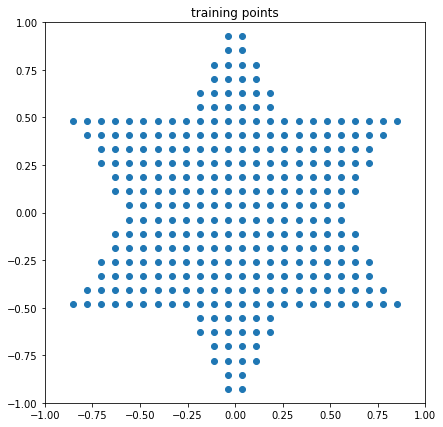

In [15]:
plt.figure(figsize=(7, 7))
plt.scatter(xx_train, yy_train)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('training points');

<IPython.core.display.Javascript object>


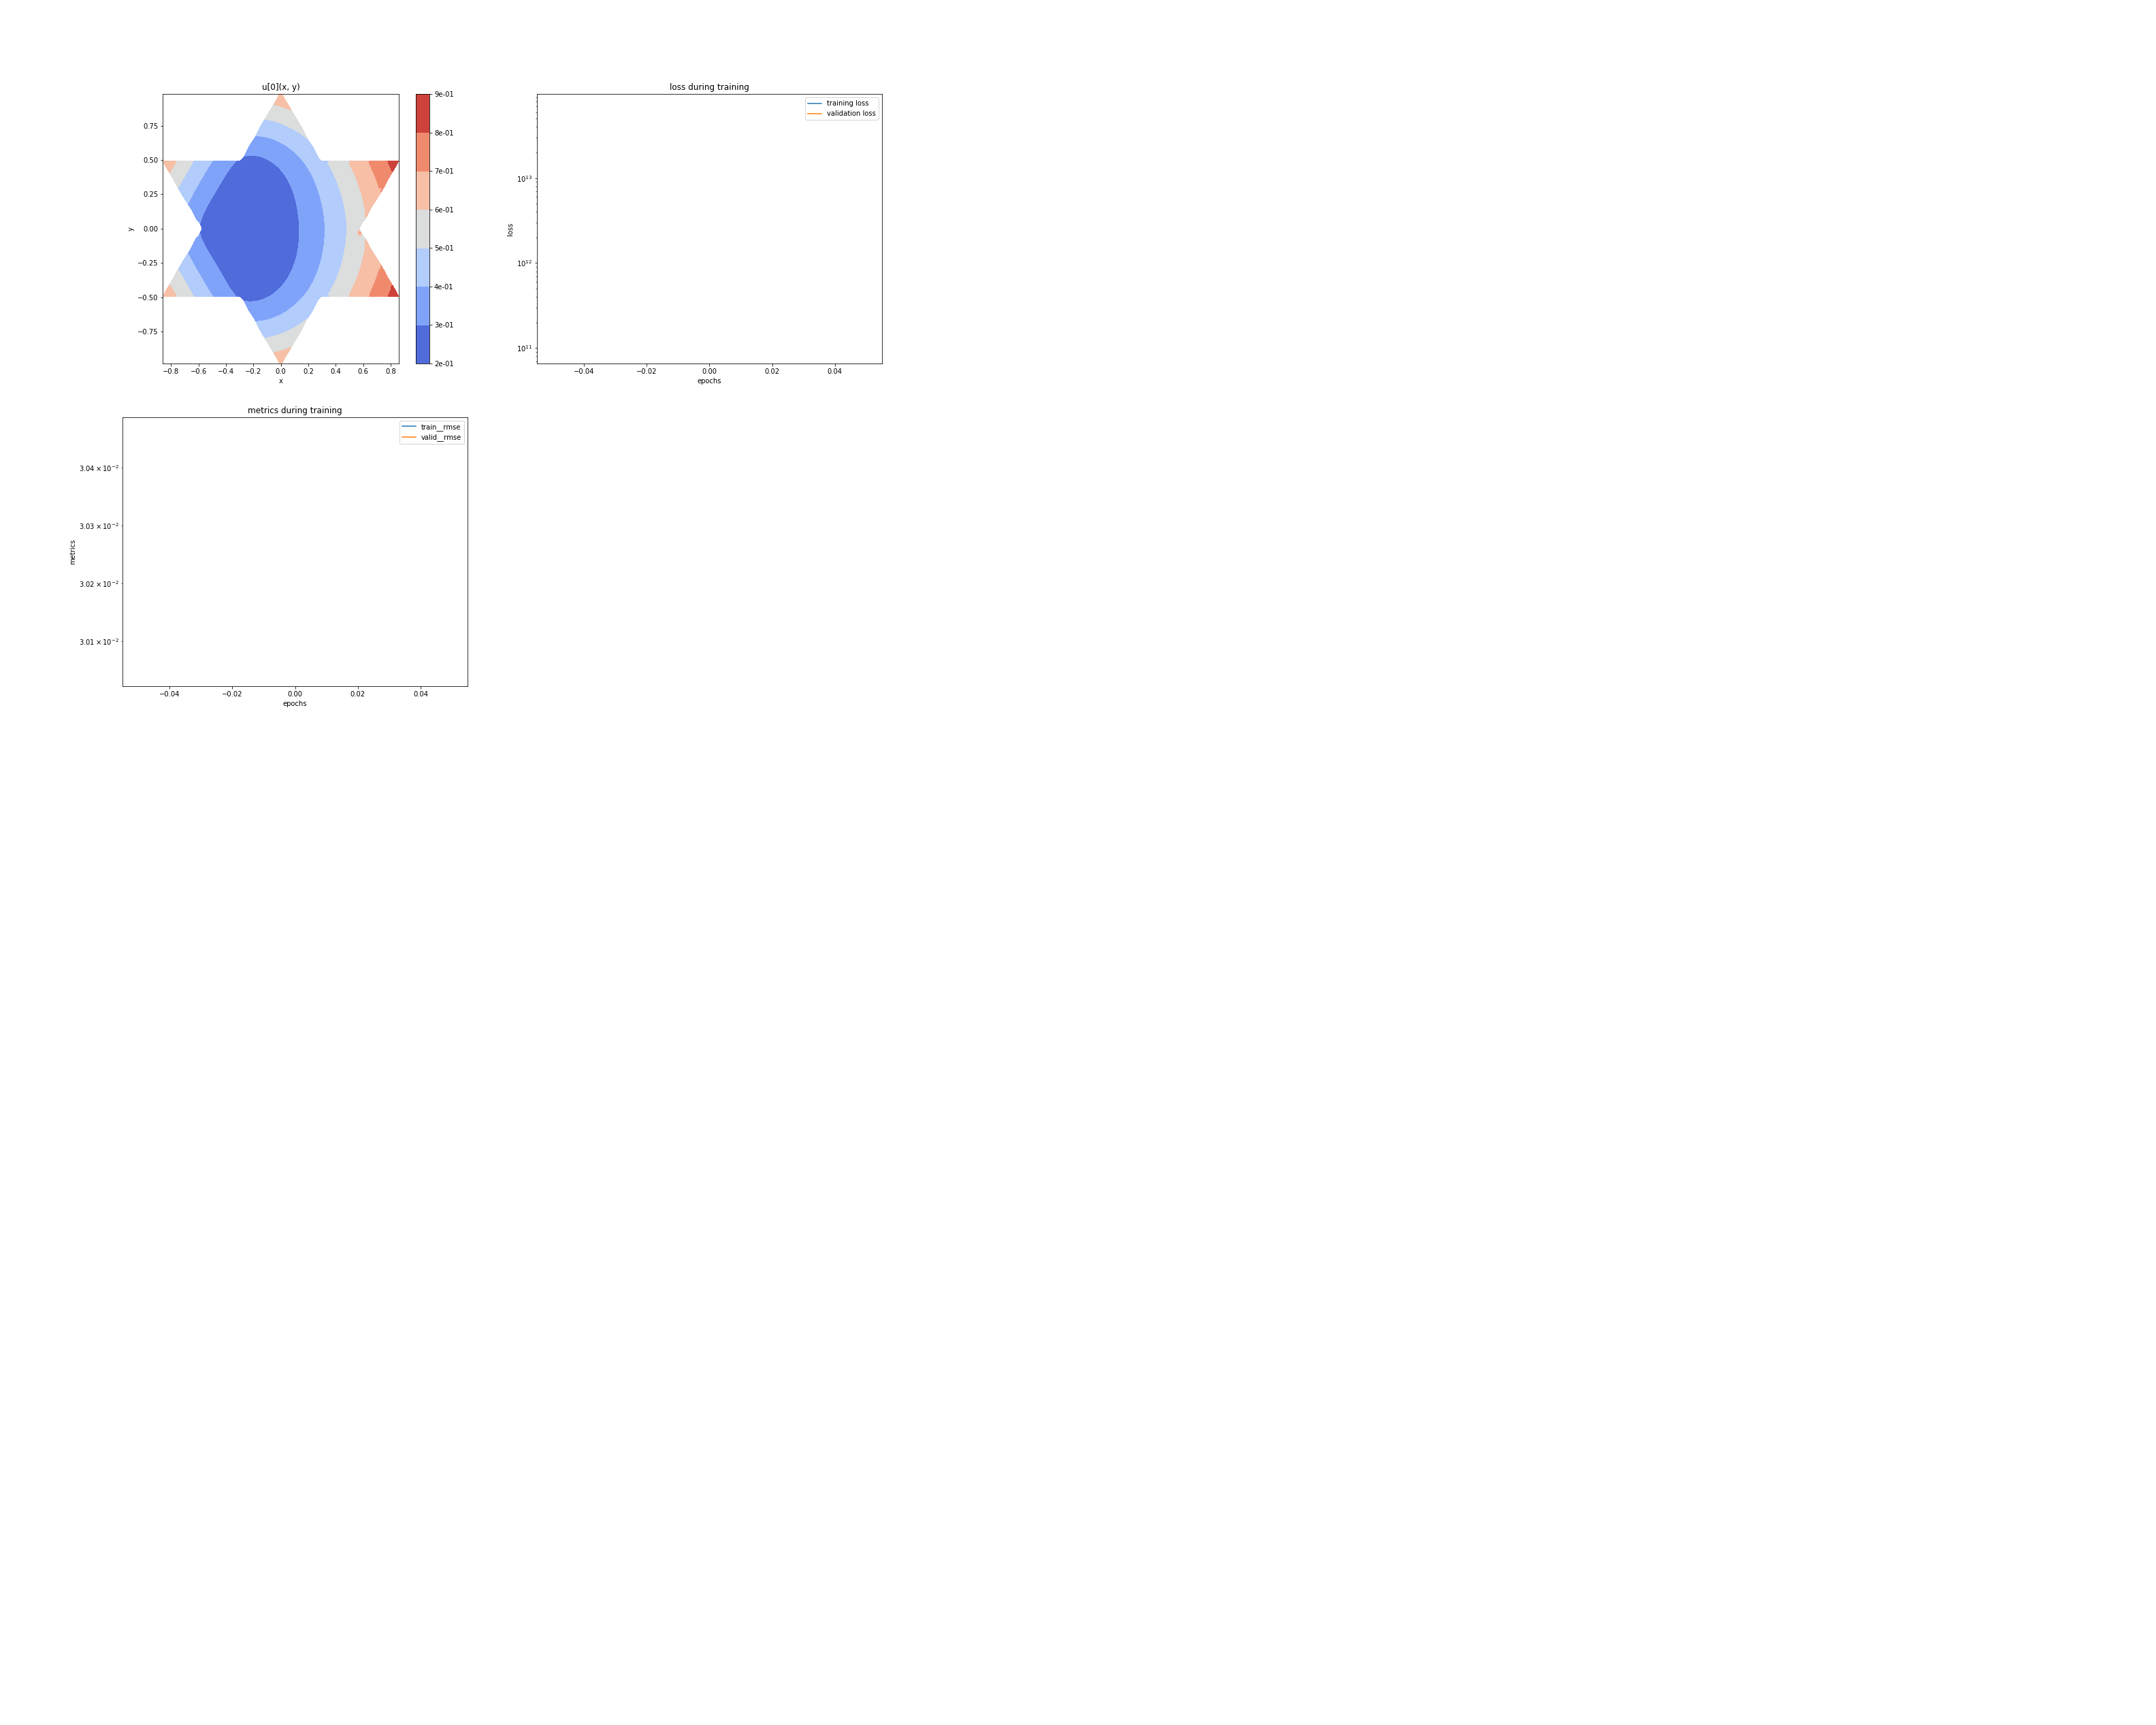

In [16]:
%matplotlib notebook
if RETRAIN_PROBLEM_C:
    
    def rmse(u, x, y):
        true_u = torch.log(1+x**2+y**2)
        return torch.mean( (u - true_u)**2 )
    
    # nabla^2 psi(x, y) = (e^(-x))(x-2+y^3+6y)
    def de_problem_c(u, x, y):
        return diff(u, x, order=2) + diff(u, y, order=2) + torch.exp(u) - 1.0 - x**2 - y**2 - 4.0/(1.0+x**2+y**2)**2

    # fully connected network with one hidden layer (40 hidden units with Sigmoid activation)
    net = FCNN(n_input_units=2, n_hidden_units=40, n_hidden_layers=1, actv=nn.Sigmoid)
    adam = optim.Adam(params=net.parameters(), lr=0.01)

    # train on 28 X 28 grid
    solution_neural_net_problem_c, history_problem_c = solve2D(
        pde=de_problem_c, condition=cbc_problem_c,
        xy_min=(-1, -1), xy_max=(1, 1),
        train_generator=train_gen, valid_generator=valid_gen,
        net=net, max_epochs=1, batch_size=train_gen.size, optimizer=adam,
        monitor=Monitor2D(check_every=1, xy_min=(-1, -1), xy_max=(1, 1), valid_generator=valid_gen),
        metrics={'rmse': rmse}
    )
%matplotlib inline

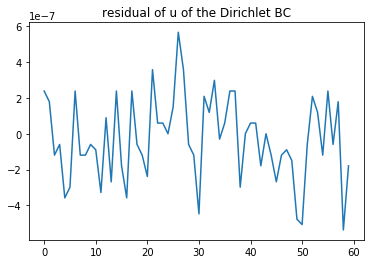

In [17]:
xs = torch.tensor([p.loc[0] for p in dirichlet_control_points_problem_c], requires_grad=True).reshape(-1, 1)
ys = torch.tensor([p.loc[1] for p in dirichlet_control_points_problem_c], requires_grad=True).reshape(-1, 1)
us = solution_neural_net_problem_c(xs, ys, as_type='np')
true_us = solution_analytical_problem_c( to_np(xs),  to_np(ys) )

plt.plot(us - true_us)
plt.title('residual of u of the Dirichlet BC');

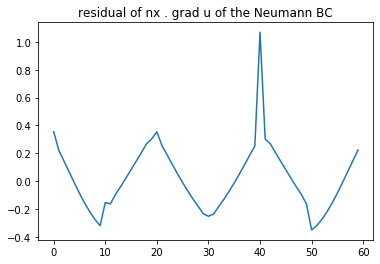

In [18]:
xs = torch.tensor([p.loc[0] for p in neumann_control_points_problem_c], requires_grad=True).reshape(-1, 1)
ys = torch.tensor([p.loc[1] for p in neumann_control_points_problem_c], requires_grad=True).reshape(-1, 1)
us = solution_neural_net_problem_c(xs, ys)
nxgradu = to_np( xs * diff(us, xs) + ys * diff(us, ys) ).flatten()
true_nxgradu = np.array([p.val for p in neumann_control_points_problem_c])

plt.plot(nxgradu - true_nxgradu)
plt.title('residual of nx . grad u of the Neumann BC');

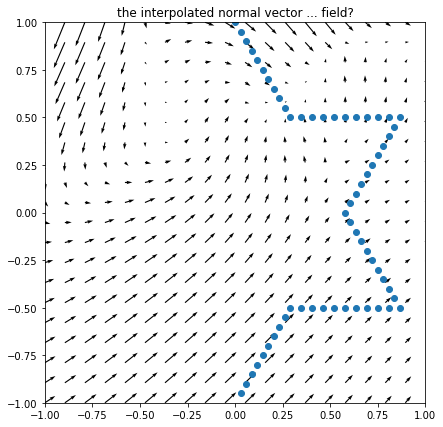

In [19]:
x = torch.linspace(-1, 1, 20)
y = torch.linspace(-1, 1, 20)
xx, yy = torch.meshgrid(x, y)
xx_normal_vector, yy_normal_vector = cbc_problem_c.n_hat(xx, yy)
xx_normal_vector = to_np(xx_normal_vector)
yy_normal_vector = to_np(yy_normal_vector)

fig, ax = plt.subplots(figsize=(7, 7))
ax.quiver(x, y, xx_normal_vector, yy_normal_vector)
ax.scatter(
    [p.loc[0] for p in neumann_control_points_problem_c],
    [p.loc[1] for p in neumann_control_points_problem_c]
)
plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('the interpolated normal vector ... field?')
plt.show()

In [20]:
xx = torch.tensor([p.loc[0] for p in neumann_control_points_problem_c])
yy = torch.tensor([p.loc[1] for p in neumann_control_points_problem_c])
xx_normal_vector_fitted, yy_normal_vector_fitted = cbc_problem_c.n_hat(xx, yy)
xx_normal_vector_fitted = to_np(xx_normal_vector_fitted)
yy_normal_vector_fitted = to_np(yy_normal_vector_fitted)
xx_normal_vector_true = np.array([p.normal_vector[0] for p in neumann_control_points_problem_c])
yy_normal_vector_true = np.array([p.normal_vector[1] for p in neumann_control_points_problem_c])
xx_normal_vector_fitted - xx_normal_vector_true, yy_normal_vector_fitted - yy_normal_vector_true, 

(array([ 6.03043569e-05, -4.95470034e-05, -7.28731029e-06, -1.39034259e-05,
         1.93559659e-05,  2.87138952e-05, -4.60510127e-06, -1.92289226e-06,
        -9.09613296e-07, -5.51985427e-07,  9.95397568e-06,  8.04662704e-07,
         4.02331352e-06, -3.87430191e-07,  4.76837158e-07,  1.34110451e-06,
        -1.78813934e-07, -1.72853470e-06,  2.95042992e-06, -5.27501106e-06,
        -6.03561275e-06,  1.63270310e-07, -5.43956630e-06, -4.96272914e-06,
        -3.17458980e-06, -2.75735728e-06,  4.40610203e-08, -2.22091548e-06,
         2.78587468e-06, -6.71194717e-07, -2.63814799e-06,  3.62033971e-06,
        -2.45933406e-06,  6.36215337e-06,  1.71299107e-06,  4.45480473e-06,
        -7.51482692e-08, -4.96272914e-06,  1.22034086e-05, -7.94296138e-06,
        -1.10268593e-05, -7.12275505e-06, -1.84476376e-05, -1.19209290e-05,
        -8.22544098e-06, -1.48117542e-05, -1.71065331e-05, -1.03414059e-05,
        -5.69224358e-06, -1.24871731e-05, -8.77742641e-06, -5.32035701e-06,
         2.5

In [21]:
neumann_control_points_problem_c

[NeumannControlPoint((0.0, 1.0), val=0.49999999999999994, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.028867513459481298, 0.95), val=0.5253940455341505, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.057735026918962595, 0.8999999999999999), val=0.551470588235294, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.08660254037844389, 0.8499999999999999), val=0.5780346820809248, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.11547005383792519, 0.7999999999999998), val=0.6048387096774194, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.1443375672974065, 0.7499999999999998), val=0.631578947368421, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0.17320508075688779, 0.6999999999999997), val=0.6578947368421053, normal_vector=(0.8660254037844387, 0.49999999999999994)),
 NeumannControlPoint((0